In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sobol
import GPy
import scipy
import optunity

# 1 GP Optimization of a Toy Problem

Implementation and visualization of $f(x,y)$.

In [3]:
def f(x,y):
    return np.square(x) - x + np.square(y) + y - np.cos((2*x -1 )*np.pi) - np.cos((2*y + 1)*np.pi) + 2.5

In [4]:
def visualization(datapoints=None):
    X = np.arange(-6,6,0.05)
    X, Y = np.meshgrid(X, X)
    Z = f(X, Y)

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    plot = ax.contour(X,Y,Z,20, cmap='inferno')
    plt.colorbar(plot)
    
    if datapoints is not None:
        plt.scatter(datapoints[:,0], datapoints[:,1], color='g', marker='x')
        plt.scatter([0.5], [-0.5], color='r', marker='o')

    plt.show()

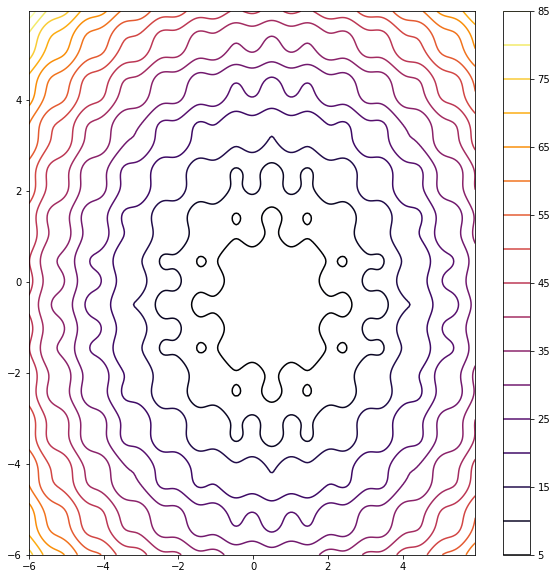

In [5]:
visualization()

Creating initial 30 training points using sobol and computing the corresponding Z-values.

In [6]:
number_of_samples = 30
X = np.zeros([number_of_samples,2]) #training vector to be filled
parameterUpperLimits = np.array([6,6])
parameterLowerLimits = np.array([-6, -6])
for i in range(number_of_samples):
    X[i,:] = sobol.i4_sobol(2,i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    
Z = f(X[:,0],X[:,1])[:,None]

Implementation of both utility functions ("Maximal Improvement" and "Maximal Variance"). Which one create can be determined by the argument "ut_fct".

In [7]:
def create_utility_fct(model, E_best, ut_fct):
    
    def u_EI(q_x, q_y): # expected improvement
        # q has to be a numpy array with shape (1,2)
        q = np.array([[q_x, q_y]])
        E_q, Var_q = model.predict(q)
        gamma_q = (E_best - E_q) / np.sqrt(Var_q)
        u = np.sqrt(Var_q) * (gamma_q * scipy.stats.norm.cdf(gamma_q) + scipy.stats.norm.pdf(gamma_q))

        return u[0,0]
    
    def u_MV(q_x, q_y): # maximal variance
        q = np.array([[q_x, q_y]])
        Var_q = model.predict(q)[1]
        
        return Var_q
    
    if ut_fct == 'ExpImpr':
        return u_EI
    
    elif ut_fct == 'MaxVar':
        return u_MV

Here, we use the optunity module to find the best new point according to the chosen utility function.

In [8]:
def update(X, Z, model, ut_fct):
    E_best = np.min(Z) #E_best is the smallest value from the current training set
    u = create_utility_fct(model, E_best, ut_fct)
    # find point q which maximizes the expected improvement using optunity
    q_max = optunity.maximize(u, num_evals=100, q_x=[-6,6], q_y=[-6,6])
    q_x = q_max[0]['q_x']
    q_y = q_max[0]['q_y']
    z = f(q_x, q_y) # compute corresponding function value
    # add data point to training set
    X_new = np.concatenate((X, np.array([[q_x, q_y]])), axis=0)
    Z_new = np.concatenate((Z, np.array([[z]])), axis=0)
    
    # train model with new training set
    kernel = GPy.kern.RBF(2) + GPy.kern.White(2)
    model = GPy.models.GPRegression(X_new ,Z_new, kernel)
    model.optimize()
    
    return X_new, Z_new, model

Now, we iterate over 30 epochs only using the "Maximal Improvement" utility function.

In [9]:
# create copies of training set and model since they will be modified in the following,
# but the same base values will be needed later
X_ExpImp = X.copy()
Z_ExpImp = Z.copy()

In [10]:
kernel = GPy.kern.RBF(2) + GPy.kern.White(2)
m_ExpImp = GPy.models.GPRegression(X_ExpImp, Z_ExpImp, kernel)
m_ExpImp.optimize()

In [11]:
for i in range(30):
    X_ExpImp, Z_ExpImp, m_ExpImp = update(X_ExpImp, Z_ExpImp, m_ExpImp, 'ExpImpr')
    # print true function value and prediction by GP of the newest training point in each iteration
    print("Iteration: %2d, f(x,y) = %3.2f, GP_pred = %3.2f" % (i, Z_ExpImp[-1,0], m_ExpImp.predict(X_ExpImp[-1,:][None,:])[0][0,0]))

Iteration:  0, f(x,y) = 1.04, GP_pred = 1.89
Iteration:  1, f(x,y) = 1.19, GP_pred = 1.80
Iteration:  2, f(x,y) = 0.34, GP_pred = 1.61
Iteration:  3, f(x,y) = 0.08, GP_pred = 1.47
Iteration:  4, f(x,y) = 0.33, GP_pred = 1.33
Iteration:  5, f(x,y) = 0.07, GP_pred = 1.23
Iteration:  6, f(x,y) = 0.90, GP_pred = 1.20
Iteration:  7, f(x,y) = 1.40, GP_pred = 1.26
Iteration:  8, f(x,y) = 1.74, GP_pred = 1.26
Iteration:  9, f(x,y) = 0.74, GP_pred = 1.22
Iteration: 10, f(x,y) = 1.11, GP_pred = 1.20
Iteration: 11, f(x,y) = 0.03, GP_pred = 1.15
Iteration: 12, f(x,y) = 0.12, GP_pred = 1.10
Iteration: 13, f(x,y) = 0.55, GP_pred = 1.05
Iteration: 14, f(x,y) = 0.55, GP_pred = 0.55
Iteration: 15, f(x,y) = 4.36, GP_pred = 3.62
Iteration: 16, f(x,y) = 1.74, GP_pred = 1.11
Iteration: 17, f(x,y) = 0.55, GP_pred = 1.06
Iteration: 18, f(x,y) = 0.46, GP_pred = 1.03
Iteration: 19, f(x,y) = 0.18, GP_pred = 0.99
Iteration: 20, f(x,y) = 1.08, GP_pred = 1.01
Iteration: 21, f(x,y) = 0.16, GP_pred = 0.97
Iteration:

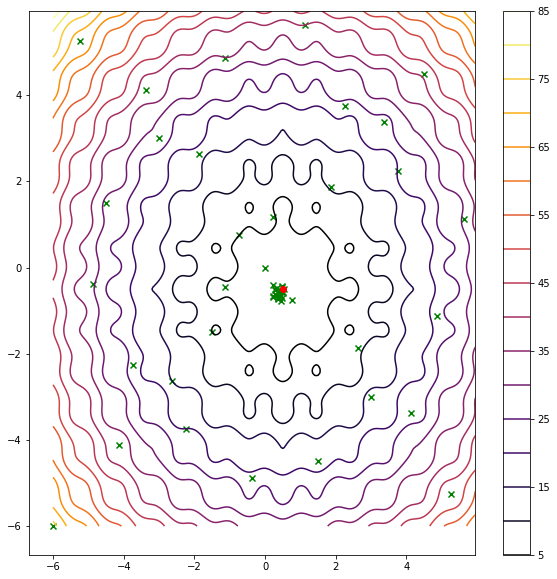

In [12]:
visualization(X_ExpImp)

The global optimum is represented by the red dot whereas points in the final training set are represented by green crosses. We observe a strong accumulation of training points close to the global optimum. However these accumulated points seem no to be centered around the optimum but are slightly shifted to the lower left. Further, we see that many points are located at the same function value/same level whereas other levels are not exploited at all.

Now, we repeat the same procedure for alternating utility functions:

In [13]:
X_Alt = X.copy()
Z_Alt = Z.copy()

kernel = GPy.kern.RBF(2) + GPy.kern.White(2)
m_Alt = GPy.models.GPRegression(X_Alt, Z_Alt, kernel)
m_Alt.optimize()
basic_model = m_Alt.copy() # model that will not further be optimized and is needed for later visualization

 /usr/local/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [14]:
for i in range(15):
    X_Alt, Z_Alt, m_Alt = update(X_Alt, Z_Alt, m_Alt, 'ExpImpr')
    # print true function value and prediction by GP of the newest training point in each iteration
    print("Iteration: %2d, f(x,y) = %3.2f, GP_pred = %3.2f" % (2*i, Z_Alt[-1,0], m_Alt.predict(X_Alt[-1,:][None,:])[0][0,0]))
    
    X_Alt, Z_Alt, m_Alt = update(X_Alt, Z_Alt, m_Alt, 'MaxVar')
    # print true function value and prediction by GP of the newest training point in each iteration
    print("Iteration: %2d, f(x,y) = %3.2f, GP_pred = %3.2f" % (2*i+1, Z_Alt[-1,0], m_Alt.predict(X_Alt[-1,:][None,:])[0][0,0]))

Iteration:  0, f(x,y) = 1.47, GP_pred = 1.96
Iteration:  1, f(x,y) = 45.57, GP_pred = 44.68
Iteration:  2, f(x,y) = 0.88, GP_pred = 1.79
Iteration:  3, f(x,y) = 75.08, GP_pred = 73.13
Iteration:  4, f(x,y) = 1.01, GP_pred = 1.60
Iteration:  5, f(x,y) = 56.91, GP_pred = 57.07
Iteration:  6, f(x,y) = 0.66, GP_pred = 1.51
Iteration:  7, f(x,y) = 79.59, GP_pred = 79.77
Iteration:  8, f(x,y) = 1.06, GP_pred = 1.51
Iteration:  9, f(x,y) = 52.55, GP_pred = 51.65
Iteration: 10, f(x,y) = 0.16, GP_pred = 1.36
Iteration: 11, f(x,y) = 34.00, GP_pred = 33.26
Iteration: 12, f(x,y) = 0.10, GP_pred = 1.27
Iteration: 13, f(x,y) = 33.14, GP_pred = 32.47
Iteration: 14, f(x,y) = 0.23, GP_pred = 1.22
Iteration: 15, f(x,y) = 48.60, GP_pred = 47.83
Iteration: 16, f(x,y) = 0.23, GP_pred = 1.15
Iteration: 17, f(x,y) = 49.05, GP_pred = 49.33
Iteration: 18, f(x,y) = 0.37, GP_pred = 1.11
Iteration: 19, f(x,y) = 40.43, GP_pred = 38.61
Iteration: 20, f(x,y) = 0.65, GP_pred = 1.09
Iteration: 21, f(x,y) = 50.75, GP_p

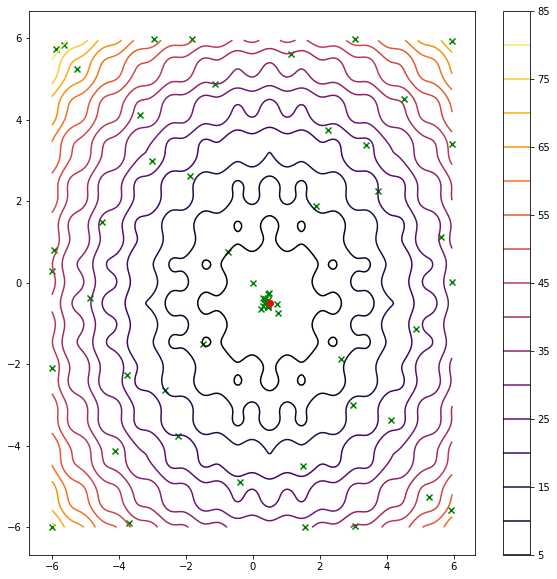

In [15]:
visualization(X_Alt)

In this case, there seem to be less points around the global obtimum than previously, but they are distributed more symmetrically. Further we see, that the points seem to be better distributed as more different levels of the function are explored (e.g. also at the borders).

As a baseline, we create 60 uniformly distributed points and compare their minimum to the ones found above:

In [16]:
points = np.random.uniform(low=-6, high=6, size=(60,2))
minimum = np.min(f(points[:,0], points[:,1]))

print("random points: %1.3f" % minimum)
print("ExpImpr: %1.3f" % (np.min(Z_ExpImp)))
print("Alternating: %1.3f" % (np.min(Z_Alt)))

random points: 1.077
ExpImpr: 0.029
Alternating: 0.087


As one can see, the alternating utility functions provide best result whereas the minimum obtained using the random points is far away from the real global optimum.

Now, we visualize the GP's approximation after training with 30 and 60 data points respectively.

In [17]:
def visualize_model(model):
    X = np.arange(-6,6,0.05)
    X, Y = np.meshgrid(X, X)
    input_data = np.array([X.flatten(), Y.flatten()]).T
    
    Z = model.predict(input_data)[0].reshape(240,240)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    plot = ax.contour(X,Y,Z,20, cmap='inferno')
    plt.colorbar(plot)
    plt.show()

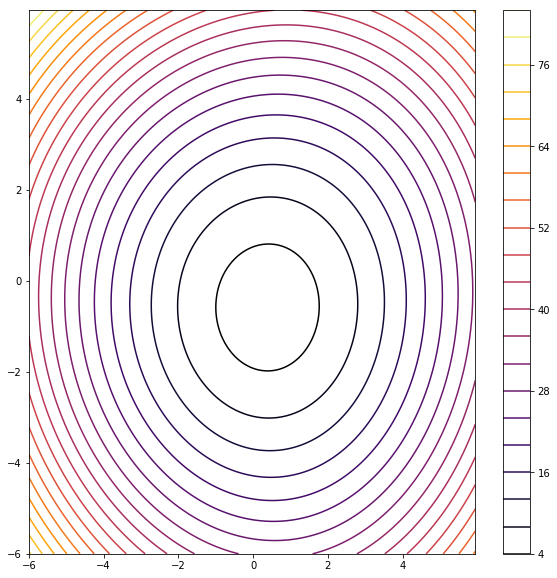

In [18]:
visualize_model(basic_model)

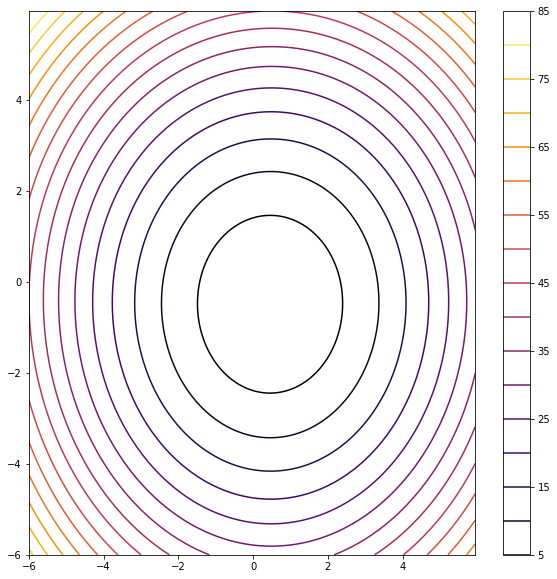

In [19]:
visualize_model(m_Alt)

# 2 Reconstruction of a Corrupted Image

In [20]:
from ridge_regression import *

kernel_ridge_regression(tau=0.3, sigma=4.0)

training...
building input kernel matrix
sparsity: 0.91%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 6.01 seconds.
(338, 250)


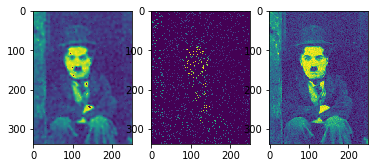

In [21]:
import matplotlib.image as mpimg
img1 = mpimg.imread('res.png')
img2 = mpimg.imread('cc_90.png')
img3 = mpimg.imread('charlie-chaplin.jpg')

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.show()

The function utilizes `scipy.sparse.linalg.cg` which is able to solve `Ax = b` for `x`. Thus it does not need to invert `A` in order to solve `x = b A.inv`. <br>

The function also uses `sparse` matrices for faster computation since these are much faster if most elements of the matrix are 0 as in this case.

# 3 Bayesian Optimization of Hyperparameters

In [22]:
def COR(A, B):
    A_dash = A.mean()
    B_dash = B.mean()
    num = np.sum(np.sum((A - A_dash)*(B - B_dash)))
    denom = np.sqrt(np.sum(np.sum((A - A_dash)**2))) * np.sqrt(np.sum(np.sum((B - B_dash)**2)))
    return num/denom

In [23]:
COR(img1, img3)

0.92878205944060455